## 95-851: Social Media Analysis
### Data Clan
#### Part 1: Sentiment Analysis

### 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
Both_iPhones_data = pd.read_csv('Both_iPhones_data.csv')
both_samsung_and_iphone_data = pd.read_csv('both_samsung_and_iphone_data.csv')
iphone8_data = pd.read_csv('iphone8_data.csv')
iphoneX_data = pd.read_csv('iphoneX_data.csv')
samsung_data = pd.read_csv('samsung_data.csv')

### 2. Exploratory Data Analysis

In [3]:
# add new column with device type
Both_iPhones_data['device_type'] = 'Both iPhone 8 & iPhone X'
both_samsung_and_iphone_data['device_type'] = 'Both Samsung & iPhone'
iphone8_data['device_type'] = 'iPhone 8'
iphoneX_data['device_type'] = 'iPhone X'
samsung_data['device_type'] = 'Samsung'

In [4]:
# concatenate all data into one df
all_data = pd.concat([Both_iPhones_data,both_samsung_and_iphone_data,iphone8_data,iphoneX_data,samsung_data], sort=True)

In [5]:
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

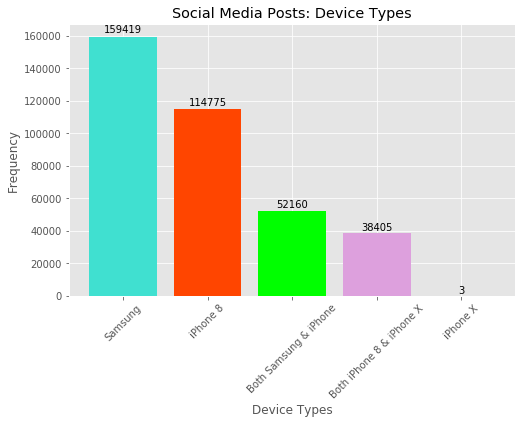

In [6]:
from collections import Counter
from operator import itemgetter
c=['turquoise', 'orangered', 'lime', 'plum', 'gold']

counts_per_device_type = Counter()
for device_type in all_data.device_type:
    counts_per_device_type[device_type] +=1
    
counts_per_device_type_sorted = sorted(counts_per_device_type.items(),
                                  reverse=True,
                                  key=itemgetter(1))

device_types = [device_type for device_type, count in counts_per_device_type_sorted]
counts = [count for device_type, count in counts_per_device_type_sorted]

plt.figure(figsize=(8, 5))
bar1 = plt.bar(range(len(device_types)), counts, color = c)
plt.xlabel('Device Types')
plt.xticks(range(len(device_types)), device_types, rotation=45)
plt.ylabel('Frequency')
plt.title("Social Media Posts: Device Types")
autolabel(bar1)
plt.show()

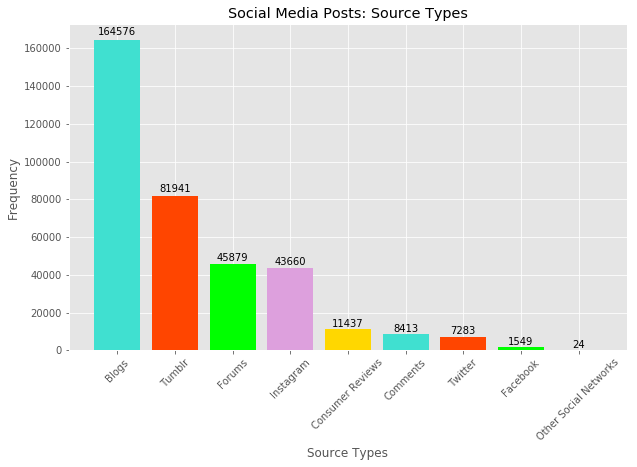

In [7]:
from collections import Counter
from operator import itemgetter
c=['turquoise', 'orangered', 'lime', 'plum', 'gold']
counts_per_source_type = Counter()
for source_type in all_data["Source Type"]:
    counts_per_source_type[source_type] +=1
    
counts_per_source_type_sorted = sorted(counts_per_source_type.items(),
                                  reverse=True,
                                  key=itemgetter(1))

source_types = [source_type for source_type, count in counts_per_source_type_sorted]
counts = [count for source_type, count in counts_per_source_type_sorted]

plt.figure(figsize=(10, 6))
bar2 = plt.bar(range(len(source_types)), counts, color = c)
plt.xlabel('Source Types')
plt.xticks(range(len(source_types)), source_types, rotation=45)
plt.ylabel('Frequency')
plt.title("Social Media Posts: Source Types")
autolabel(bar2)
plt.show()

### 3. Data Preprocessing

In [9]:
%%time
# remove punctuation
import string
all_data.LowerText = all_data.LowerText.apply(lambda x: x.translate(string.punctuation))

Wall time: 16.4 s


In [10]:
%%time
# remove numbers
all_data.LowerText = all_data.LowerText.apply(lambda x: x.translate(string.digits))

Wall time: 15 s


In [11]:
%%time
#tokenize
all_data["Tokenized_Text"] = all_data.LowerText.apply(lambda x: x.split(' '))

Wall time: 8.55 s


In [12]:
%%time
# stem
import nltk
from nltk.stem.porter import PorterStemmer
all_data["Stemmed_text"] = all_data.Tokenized_Text.apply(lambda x: [PorterStemmer().stem(y) for y in x])

Wall time: 13min


In [15]:
%%time
# remove stopwords
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')
sw = stopwords.words('english')
all_data.Stemmed_text = all_data.Stemmed_text.apply(lambda x: [item for item in x if item not in sw])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dpc50\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Wall time: 1min 12s


### 4. Create Sentiment Analysis Models

In [16]:
%%time
from textblob import TextBlob
all_data['TextBlob_sentiment'] = np.array([TextBlob(text).sentiment.polarity for text in all_data['Sound Bite Text']])

Wall time: 6min 30s


In [17]:
%%time
from afinn import Afinn
afn = Afinn(emoticons=True)
all_data["Afn_Sent"] = all_data["Sound Bite Text"].apply(lambda x: afn.score(x))

Wall time: 21min 18s


In [50]:
import spacy
nlp = spacy.load('en')
from nltk.corpus import sentiwordnet as swn

def analyze_sentiment_sentiwordnet_lexicon(review,
                                           verbose=False):

    # tokenize and POS tag text tokens
    tagged_text = [(token.text, token.tag_) for token in nlp(review)]
    pos_score = neg_score = token_count = obj_score = 0
    # get wordnet synsets based on POS tags
    # get sentiment scores if synsets are found
    for word, tag in tagged_text:
        ss_set = None
        if 'NN' in tag and list(swn.senti_synsets(word, 'n')):
            ss_set = list(swn.senti_synsets(word, 'n'))[0]
        elif 'VB' in tag and list(swn.senti_synsets(word, 'v')):
            ss_set = list(swn.senti_synsets(word, 'v'))[0]
        elif 'JJ' in tag and list(swn.senti_synsets(word, 'a')):
            ss_set = list(swn.senti_synsets(word, 'a'))[0]
        elif 'RB' in tag and list(swn.senti_synsets(word, 'r')):
            ss_set = list(swn.senti_synsets(word, 'r'))[0]
        # if senti-synset is found        
        if ss_set:
            # add scores for all found synsets
            pos_score += ss_set.pos_score()
            neg_score += ss_set.neg_score()
            obj_score += ss_set.obj_score()
            token_count += 1
    
    # aggregate final scores
    final_score = pos_score - neg_score
    norm_final_score = 0
    if(token_count != 0):    
        norm_final_score = round(float(final_score) / token_count, 2)
    
    final_sentiment = 'positive' if norm_final_score >= 0 else 'negative'
    if verbose:
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        # to display results in a nice table
        sentiment_frame = pd.DataFrame([[final_sentiment, norm_obj_score, norm_pos_score, 
                                         norm_neg_score, norm_final_score]],
                                       columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                             ['Predicted Sentiment', 'Objectivity',
                                                              'Positive', 'Negative', 'Overall']], 
                                                             labels=[[0,0,0,0,0],[0,1,2,3,4]]))
        print(sentiment_frame)
        
    return norm_final_score

In [51]:
%%time 
all_data["Sentwordnet_sent"] = all_data["Sound Bite Text"].apply(lambda x: analyze_sentiment_sentiwordnet_lexicon(x))

Wall time: 4h 15min 40s


In [21]:
%%time 
# vader model
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
all_data['Vader_Sentiment'] =  all_data['Sound Bite Text'].apply(lambda x: float(sia.polarity_scores(x)['compound']))

Wall time: 15min 3s


In [52]:
all_data.to_csv("all_data_sent.csv",index = False)

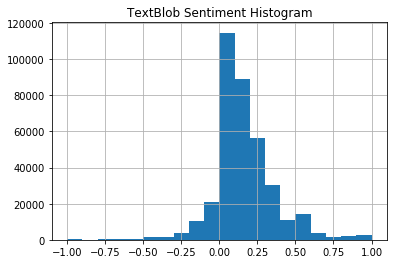

In [139]:
all_data.TextBlob_sentiment.hist(bins = 20)
plt.title("TextBlob Sentiment Histogram")
plt.show()

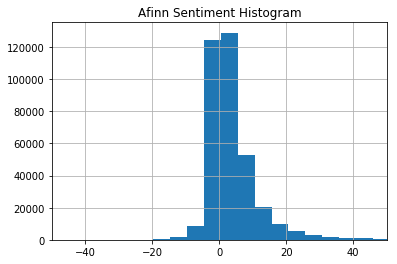

In [140]:
all_data.Afn_Sent.hist(bins = 100)
plt.title("Afinn Sentiment Histogram")
plt.xlim(-50,50)
plt.show()

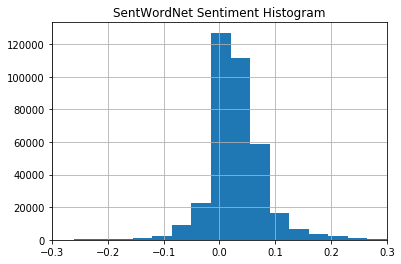

In [141]:
all_data.Sentwordnet_sent.hist(bins = 50)
plt.title("SentWordNet Sentiment Histogram")
plt.xlim(-.3,.3)
plt.show()

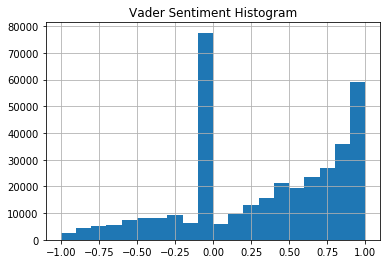

In [142]:
all_data.Vader_Sentiment.hist(bins = 20)
plt.title("Vader Sentiment Histogram")

plt.show()

In [117]:
twitter_data = all_data[all_data["Source Type"] == "Twitter"]
twitter_data.shape

(7283, 22)

In [121]:
twitter_df = pd.DataFrame(twitter_data)
twitter_df.columns = all_data.columns
twitter_df["sent_diff"] = abs(twitter_df.TextBlob_sentiment - twitter_df.Sentwordnet_sent)

In [124]:
sorted_twitter = twitter_df.sort_values(by = "sent_diff",ascending = False)

In [129]:

for i in range(5):
    text = sorted_twitter.iloc[i,5]
    print(text)
    
    for y in range(14,18):
        print(sorted_twitter.columns[y],sorted_twitter.iloc[i,y])
    print()

I added a video to a @YouTube playlist youtu.be/0MxC9sVp6mg?a Apple Iphone 8 Ringtone Awesome (Never Ever)
TextBlob_sentiment 1.0
Afn_Sent 4.0
Vader_Sentiment 0.6249
Sentwordnet_sent -0.1

Report: Galaxy S8 Prototypes Impressed At MWC 2017 dlvr.it/NYHFyP @slideme pic.twitter.com/OW9WIvw2uX
TextBlob_sentiment 1.0
Afn_Sent 3.0
Vader_Sentiment 0.4767
Sentwordnet_sent -0.08

Apple Leak Reveals iPhone 8 Nasty Surprises newssummedup.com/a/wps1fy fb.me/3gKqVChkT
TextBlob_sentiment -1.0
Afn_Sent -4.0
Vader_Sentiment -0.6249
Sentwordnet_sent 0.03

Just received my galaxy S8 plus and one of my earphones don't work Sprint won't do anything. Service is terrible. @sprint #sprintservice
TextBlob_sentiment -1.0
Afn_Sent 0.0
Vader_Sentiment -0.4767
Sentwordnet_sent 0.01

What’s the Best #Samsung Galaxy S8 Case? 5 Affordable Ways to Protect Your Investment muo.co/2s3YDH3 pic.twitter.com/8y49tQEIPJ
TextBlob_sentiment 1.0
Afn_Sent 6.0
Vader_Sentiment 0.7783
Sentwordnet_sent 0.0



In [118]:
random_data = np.random.permutation(twitter_data)[:10]
random_tweets_df = pd.DataFrame(random_data)
random_tweets_df.columns = all_data.columns

,LowerText,Media Type,Post ID,Post Type,Published Date (GMT-04:00) New York,Sound Bite Text,Source Type,contain8,containSamsung,containX,...,Stemmed_text,TextBlob_sentiment,Afn_Sent,Vader_Sentiment,Sentwordnet_sent,price_text,value_text,quality_text,Date,sent_diff
3,i liked a @youtube video youtu.be/n2wjlnnjrhi?...,Link,911756621767958530,Original,"Sep 23, 2017 8:58:12 PM",I liked a @YouTube video youtu.be/n2wJLnNJRHI?...,Twitter,True,False,False,...,"['like', '@youtub', 'video', 'youtu.be/n2wjlnn...",0.71875,3,-0.2446,0.05,False,False,False,2017-09-23 20:58:12,0.66875
7,i liked a @youtube video youtu.be/xkjblk52d1w?...,Link,854526508865646592,Original,"Apr 18, 2017 10:46:10 PM",I liked a @YouTube video youtu.be/xKjbLK52D1w?...,Twitter,NaN,True,NaN,...,"['like', '@youtub', 'video', 'youtu.be/xkjblk5...",0.6,2,0.4215,0.02,False,False,False,2017-04-18 22:46:10,0.58
4,galaxy s8 screen resolution confirmed in lates...,Link,844516071294074880,Original,"Mar 22, 2017 7:48:16 AM",Galaxy S8 screen resolution confirmed in lates...,Twitter,NaN,True,NaN,...,"['galaxi', 's8', 'screen', 'resolut', 'confirm...",0.45,1,-0.34,0.02,False,False,True,2017-03-22 07:48:16,0.43
5,"мне понравилось видео ""iphone 8 plus vs. galax...",No Media,912175638601195521,Original,"Sep 25, 2017 12:43:14 AM","Мне понравилось видео ""iPhone 8 Plus vs. Galax...",Twitter,NaN,True,NaN,...,"['мне', 'понравилось', 'видео', '""iphon', '8',...",0,-1,-0.4278,0.17,False,False,False,2017-09-25 00:43:14,0.17
2,"android circuit: new galaxy s8 issues, microso...",Image; Link,860637802731511808,Original,"May 5, 2017 7:30:16 PM","Android Circuit: New Galaxy S8 Issues, Microso...",Twitter,NaN,True,NaN,...,"['android', 'circuit:', 'new', 'galaxi', 's8',...",0.136364,1,0.3182,0.01,False,False,False,2017-05-05 19:30:16,0.126364
1,lito 3 in 1 electroplating hard pc phone case ...,Link,904644944434008066,Original,"Sep 4, 2017 5:58:56 AM",LITO 3 in 1 Electroplating Hard PC Phone Case ...,Twitter,True,False,False,...,"['lito', '3', '1', 'electropl', 'hard', 'pc', ...",-0.291667,-1,-0.1027,-0.19,False,False,False,2017-09-04 05:58:56,0.101667
8,i added a video to a @youtube playlist youtu.b...,Link,859054448336875520,Original,"May 1, 2017 10:38:35 AM",I added a video to a @YouTube playlist youtu.b...,Twitter,True,False,False,...,"['ad', 'video', '@youtub', 'playlist', 'youtu....",0,0,0,-0.09,False,False,False,2017-05-01 10:38:35,0.09
0,leak confirms iphone 8 will be larger than iph...,Link,870450876913156096,Original,"Jun 1, 2017 9:23:55 PM",Leak Confirms iPhone 8 Will Be Larger Than iPh...,Twitter,True,False,False,...,"['leak', 'confirm', 'iphon', '8', 'larger', 'i...",0,-2,-0.34,0.05,False,False,False,2017-06-01 21:23:55,0.05
6,the new samsung galaxy s8 has finally arrived....,Image; Link,855416909285572609,Original,"Apr 21, 2017 9:44:18 AM",The new Samsung Galaxy S8 has finally arrived....,Twitter,NaN,True,NaN,...,"['new', 'samsung', 'galaxi', 's8', 'ha', 'fina...",0.0681818,0,0,0.09,True,False,False,2017-04-21 09:44:18,0.0218182
9,no root adblocker & package disabler - works o...,Link,915643244226269184,Original,"Oct 4, 2017 2:22:15 PM",NO ROOT AdBlocker & Package Disabler - works o...,Twitter,NaN,True,NaN,...,"['root', 'adblock', '&', 'packag', 'disabl', '...",0,-1,-0.4466,0,False,False,False,2017-10-04 14:22:15,0


In [81]:


for i in range(10):
    text = random_tweets_df.iloc[i,5]
    print(text)
    
    for y in range(14,18):
        print(random_tweets_df.columns[y],random_tweets_df.iloc[i,y])
    print()
    

(10 iPhone HACKS and TRICKS 2017) has been published on My Iphone 8 - myiphone8.co.uk/2017/10/15/10-… pic.twitter.com/xGGH3M88JX
TextBlob_sentiment 0.0
Afn_Sent 0.0
Vader_Sentiment -0.3034
Sentwordnet_sent 0.0

My phone is beat to fuck...where this iPhone 8 at?
TextBlob_sentiment 0.0
Afn_Sent -4.0
Vader_Sentiment 0.0
Sentwordnet_sent 0.06

California-Based Company Debuts New, Stylish Case Just in Time for the iPhone 8, iPhone 8 Plus and iPhone X Release ift.tt/2wZOIDF
TextBlob_sentiment 0.3181818181818182
Afn_Sent 0.0
Vader_Sentiment 0.0
Sentwordnet_sent 0.07

Samsung Galaxy S8 SM-G950U - 64GB - Midnight Black (AT&T) Smartphone pic.twitter.com/gvpDJKFzHC
TextBlob_sentiment -0.16666666666666666
Afn_Sent 0.0
Vader_Sentiment 0.0
Sentwordnet_sent -0.07

Surprise: Galaxy S8 has the 'best smartphone display' buff.ly/2o2gJGl
TextBlob_sentiment 1.0
Afn_Sent 3.0
Vader_Sentiment 0.743
Sentwordnet_sent 0.23

I liked a @YouTube video youtu.be/frbB28ofS_c?a iPhone 8 Triple Bad News Leak
TextBlob_se

### 5. Apply Sentiment Analysis to Quality, Price, and Value of Devices

In [1]:
import pandas as pd
all_data = pd.read_csv("all_data_sent.csv")
all_data.head()

C:\Users\dpc50\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LowerText,Media Type,Post ID,Post Type,Published Date (GMT-04:00) New York,Sound Bite Text,Source Type,contain8,containSamsung,containX,containiPhone,device_type,Tokenized_Text,Stemmed_text,TextBlob_sentiment,Afn_Sent,Vader_Sentiment,Sentwordnet_sent
0,following the naming system of the past severa...,Link,718bbba167877e763cfe851413849ed8,Original,"May 8, 2017 7:39:37 AM",Following the naming system of the past severa...,Blogs,True,False,True,True,Both iPhone 8 & iPhone X,"['following', 'the', 'naming', 'system', 'of',...","['follow', 'name', 'system', 'past', 'sever', ...",-0.035714,0.0,0.1007,0.06
1,the processing cost for the oled-based 3d touc...,No Media,17194239754920322211,Original,"May 19, 2017 7:42:09 AM",The processing cost for the OLED-based 3D Touc...,Blogs,True,False,True,True,Both iPhone 8 & iPhone X,"['the', 'processing', 'cost', 'for', 'the', 'o...","['process', 'cost', 'oled-bas', '3d', 'touch',...",0.048693,7.0,0.8020,0.04
2,the processing cost for the oled-based 3d touc...,No Media,5279493144373937172,Original,"May 19, 2017 7:42:09 AM",The processing cost for the OLED-based 3D Touc...,Blogs,True,False,True,True,Both iPhone 8 & iPhone X,"['the', 'processing', 'cost', 'for', 'the', 'o...","['process', 'cost', 'oled-bas', '3d', 'touch',...",0.021852,7.0,0.8020,0.04
3,the processing cost for the oled-based 3d touc...,No Media,10937716975525293181,Original,"May 19, 2017 7:46:00 AM",The processing cost for the OLED-based 3D Touc...,Blogs,True,False,True,True,Both iPhone 8 & iPhone X,"['the', 'processing', 'cost', 'for', 'the', 'o...","['process', 'cost', 'oled-bas', '3d', 'touch',...",0.051736,7.0,0.8873,0.04
4,we have 9 exciting iphone 8 rumors for the ult...,No Media,http://learnbonds.com/133761/iphone-8-rumors-f...,Original,"May 20, 2017 10:20:00 AM",We Have 9 Exciting iPhone 8 Rumors for the Ult...,Blogs,True,False,True,True,Both iPhone 8 & iPhone X,"['we', 'have', '9', 'exciting', 'iphone', '8',...","['9', 'excit', 'iphon', '8', 'rumor', 'ultim',...",0.163586,37.0,0.9932,0.03


In [2]:
value = ["value","worth","use","appreciate","advantage","benefit","purpose"]
price = ["\$","price","buy","sell","cost","demand","expensive","cheap","affordable","money"]
quality = ["quality","design","desplay","look","screen","battery","water","proof","performance","lens","speaker"]

In [4]:
samsung_data = all_data[all_data.device_type == "Samsung"]

In [6]:
%%time
temp = None
for i, word in enumerate(price):  
    if i == 0:
        temp = all_data.LowerText.str.contains(word) 
    else: 
        temp = temp | all_data.LowerText.str.contains(word) 

all_data['price_text'] =temp    
print(all_data['price_text'].sum())

91537
Wall time: 4.09 s


In [7]:
%%time
temp = None
for i, word in enumerate(value):  
    if i == 0:
        temp = all_data.LowerText.str.contains(word) 
    else: 
        temp = temp | all_data.LowerText.str.contains(word) 

all_data['value_text'] =temp    
print(all_data['value_text'].sum())

99398
Wall time: 2.73 s


In [8]:
%%time
temp = None
for i, word in enumerate(quality):  
    if i == 0:
        temp = all_data.LowerText.str.contains(word) 
    else: 
        temp = temp | all_data.LowerText.str.contains(word) 

all_data['quality_text'] =temp    
print(all_data['quality_text'].sum())

134186
Wall time: 4.31 s


In [9]:
all_data.device_type.unique()

array(['Both iPhone 8 & iPhone X', 'Both Samsung & iPhone', 'iPhone 8',
       'iPhone X', 'Samsung'], dtype=object)

In [10]:
import matplotlib.pyplot as plt

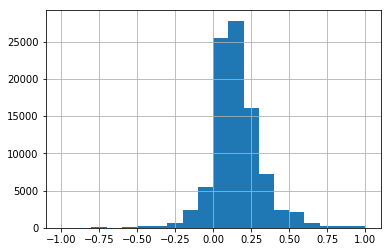

In [82]:
all_data[all_data['price_text'] == True].TextBlob_sentiment.hist(bins = 20)

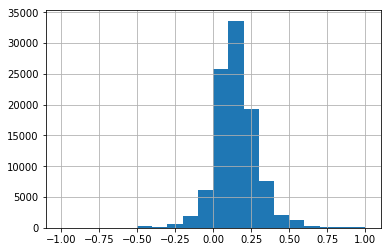

In [83]:
all_data[all_data['value_text'] == True].TextBlob_sentiment.hist(bins = 20)

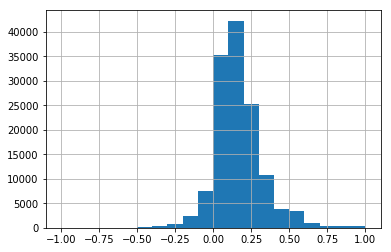

In [84]:
all_data[all_data['quality_text'] == True].TextBlob_sentiment.hist(bins = 20)

In [15]:
all_data.columns

Index(['LowerText', 'Media Type', 'Post ID', 'Post Type',
       'Published Date (GMT-04:00) New York', 'Sound Bite Text', 'Source Type',
       'contain8', 'containSamsung', 'containX', 'containiPhone',
       'device_type', 'Tokenized_Text', 'Stemmed_text', 'TextBlob_sentiment',
       'Afn_Sent', 'Vader_Sentiment', 'Sentwordnet_sent', 'price_text',
       'value_text', 'quality_text', 'Date'],
      dtype='object')

### 6. Sentiment Analysis Before and After Releases

In [14]:
%%time
all_data['Date'] = pd.to_datetime(all_data["Published Date (GMT-04:00) New York"])

Wall time: 56.2 s


In [16]:
samsung_release = "2017-04-21"
iphone_release = "2017-09-12"

In [92]:
import numpy as np
samsung_data = []
features = ["price_text","value_text","quality_text"]
for feat in features:
    sub_data = all_data[all_data.device_type == "Samsung"]
    sub_data = sub_data[sub_data[feat] == True]
    samsung_data.append([sub_data[sub_data.Date < samsung_release].TextBlob_sentiment.mean(),sub_data[sub_data.Date > samsung_release].TextBlob_sentiment.mean()])
    
samsung_data = np.array(samsung_data)

In [93]:
import numpy as np
iphone_data = []

for feat in features:
    sub_data = all_data[all_data.device_type == "iPhone 8"]
    sub_data = sub_data[sub_data[feat] == True]
    iphone_data.append([sub_data[sub_data.Date < iphone_release].TextBlob_sentiment.mean(),sub_data[sub_data.Date > iphone_release].TextBlob_sentiment.mean()])
    
iphone_data = np.array(iphone_data)

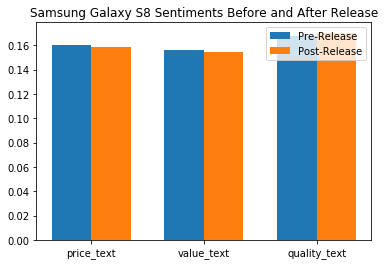

In [94]:
n = np.array(list(range(3)))
plt.bar(n,samsung_data[:,0],.35,label = "Pre-Release")
plt.bar(n+.35,samsung_data[:,1],.35,label = "Post-Release")
plt.xticks(n+.35/2,features)
plt.legend()
plt.title("Samsung Galaxy S8 Sentiments Before and After Release")
plt.show()

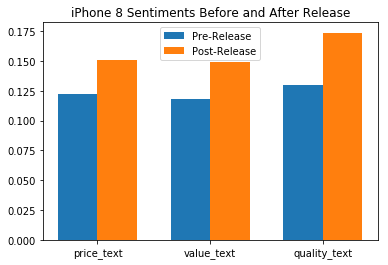

In [95]:
n = np.array(list(range(3)))
plt.bar(n,iphone_data[:,0],.35,label = "Pre-Release")
plt.bar(n+.35,iphone_data[:,1],.35,label = "Post-Release")
plt.xticks(n+.35/2,features)
plt.legend()
plt.title("iPhone 8 Sentiments Before and After Release")
plt.show()

In [96]:
samsung_sent_pre_post  = [all_data[all_data.device_type == "Samsung"][all_data[all_data.device_type == "Samsung"].Date < samsung_release].TextBlob_sentiment.mean(),all_data[all_data.device_type == "Samsung"][all_data[all_data.device_type == "Samsung"].Date > samsung_release].TextBlob_sentiment.mean()]

In [97]:
iphone_8_sent_pre_post  = [all_data[all_data.device_type == "iPhone 8"][all_data[all_data.device_type == "iPhone 8"].Date < iphone_release].TextBlob_sentiment.mean(),all_data[all_data.device_type == "iPhone 8"][all_data[all_data.device_type == "iPhone 8"].Date > iphone_release].TextBlob_sentiment.mean()]

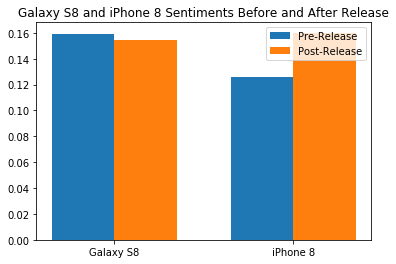

In [138]:
n = np.array(list(range(2)))
plt.bar(n,[samsung_sent_pre_post[0],iphone_8_sent_pre_post[0]],.35,label = "Pre-Release")
plt.bar(n+.35,[samsung_sent_pre_post[1],iphone_8_sent_pre_post[1]],.35,label = "Post-Release")
plt.xticks(n+.35/2,["Galaxy S8","iPhone 8"])
plt.legend()
plt.title("Galaxy S8 and iPhone 8 Sentiments Before and After Release")
plt.show()

### 7. Sentiment of Features

In [101]:
features = ["wireless charg","gb","augmented", "reality","home button","fast charge","camera","facial recognition","dual camera","repair","gear","accessory","case","fingerprint","ram","siri","sensor","bixby","battery life"]

In [102]:
feature_data =[]
for f in features:
    row = []
    for dev in ["Samsung","iPhone 8"]:
        temp_df = all_data[all_data.device_type == dev]
        dev_val = temp_df[temp_df.LowerText.str.contains(f)].TextBlob_sentiment.mean()
        row.append(dev_val)
    feature_data.append(row)
feature_data = np.array(feature_data)

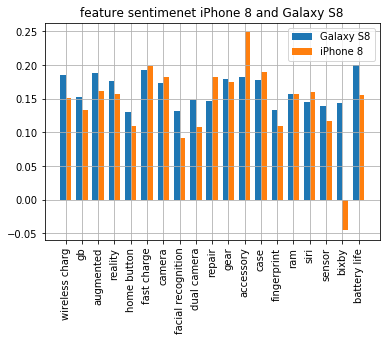

In [103]:
width = .35
ind = np.arange(len(features))
plt.bar(ind,feature_data[:,0],width,label = "Galaxy S8")
plt.bar(ind+width,feature_data[:,1],width,label = "iPhone 8")
plt.xticks(ind+width/2,features,rotation = 90)
plt.title("feature sentimenet iPhone 8 and Galaxy S8")
plt.legend()
plt.grid()
plt.show()

### 8. Twitter v. Non-Twitter data sources

In [104]:
twitter_data = []
features = ["price_text","value_text","quality_text"]
for feat in features:
    sub_data = all_data[all_data["Source Type"] == "Twitter"]
    sub_data = sub_data[sub_data[feat] == True]
    twitter_data.append(sub_data.TextBlob_sentiment.mean())
    
twitter_data = np.array(twitter_data)

In [105]:
non_twiter_data = []
features = ["price_text","value_text","quality_text"]
for feat in features:
    sub_data = all_data[all_data["Source Type"] != "Twitter"]
    sub_data = sub_data[sub_data[feat] == True]
    non_twiter_data.append(sub_data.TextBlob_sentiment.mean())
non_twiter_data = np.array(non_twiter_data)

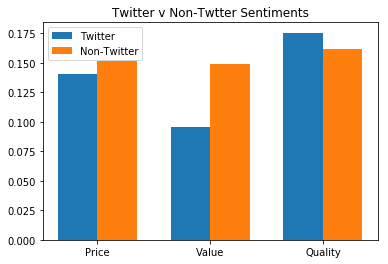

In [106]:
n = np.array(list(range(3)))
plt.bar(n,twitter_data,.35,label = "Twitter")
plt.bar(n+.35,non_twiter_data,.35,label = "Non-Twitter")
plt.xticks(n+.35/2,["Price","Value","Quality"])
plt.legend()
plt.title("Twitter v Non-Twtter Sentiments")
plt.show()

### 9. Word Cloud Data Exploration

In [107]:
from wordcloud import WordCloud, STOPWORDS
stopwords = list(STOPWORDS) +["iphone","galaxy","s8","ifttt","http","ift","tt","samsung"]
def wordcloud(text,col,stopwords):
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in text[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")

Both iPhone 8 & iPhone X


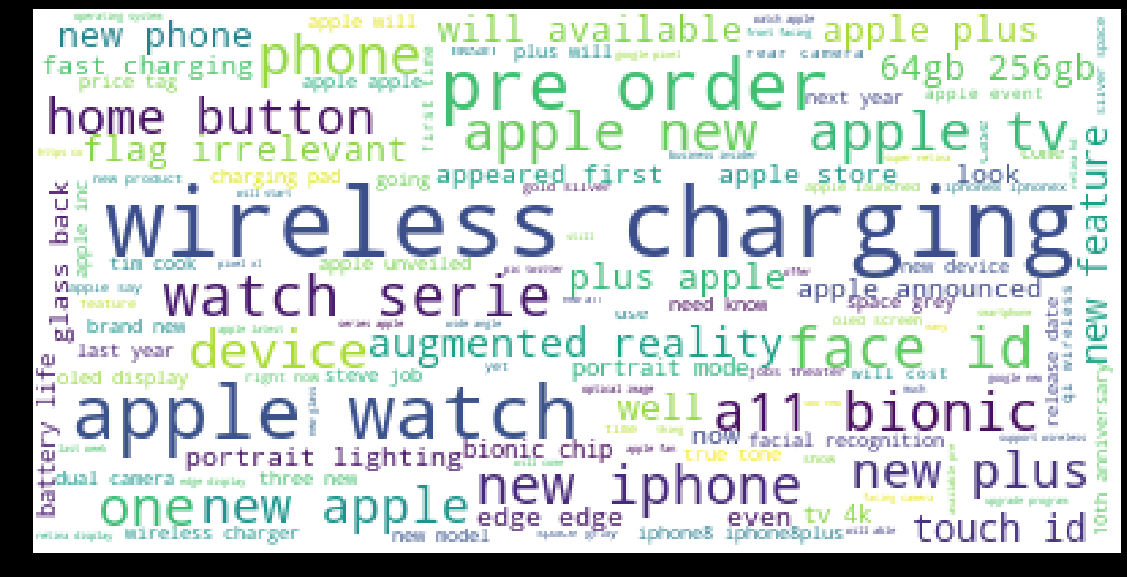

Both Samsung & iPhone


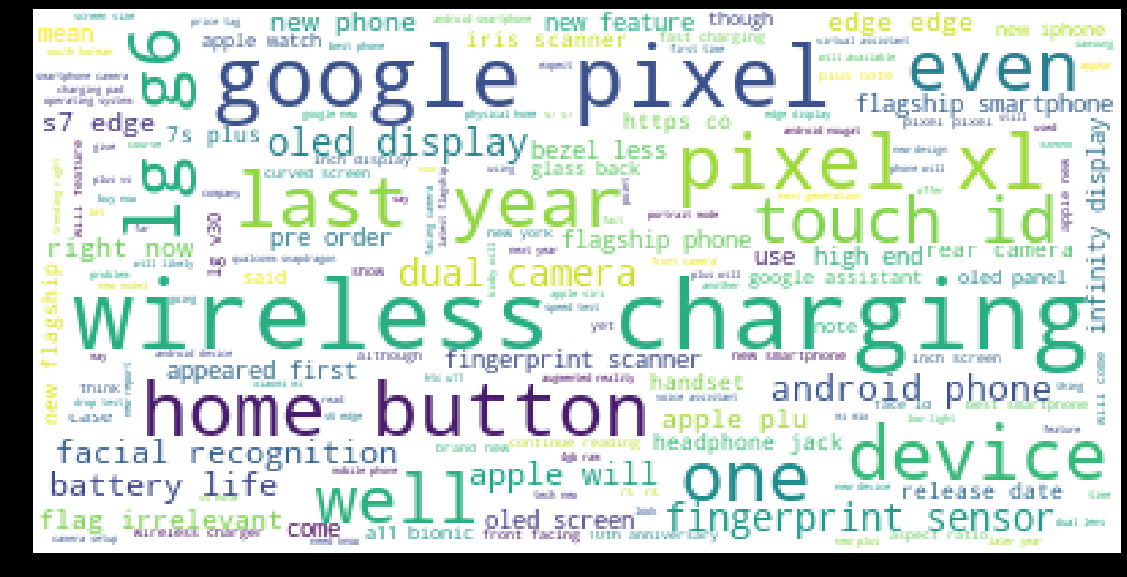

iPhone 8


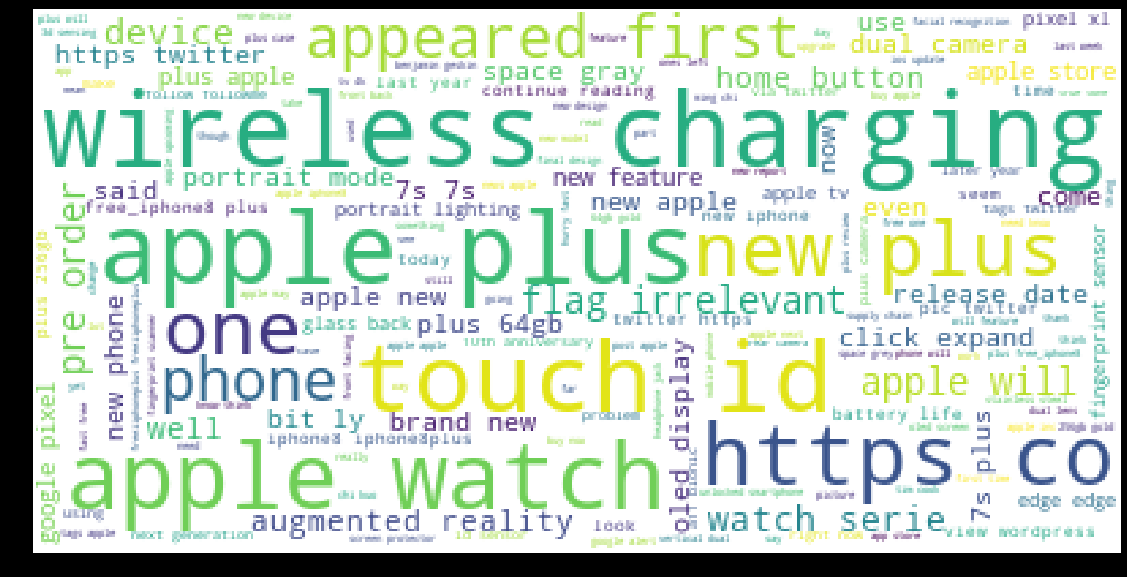

iPhone X


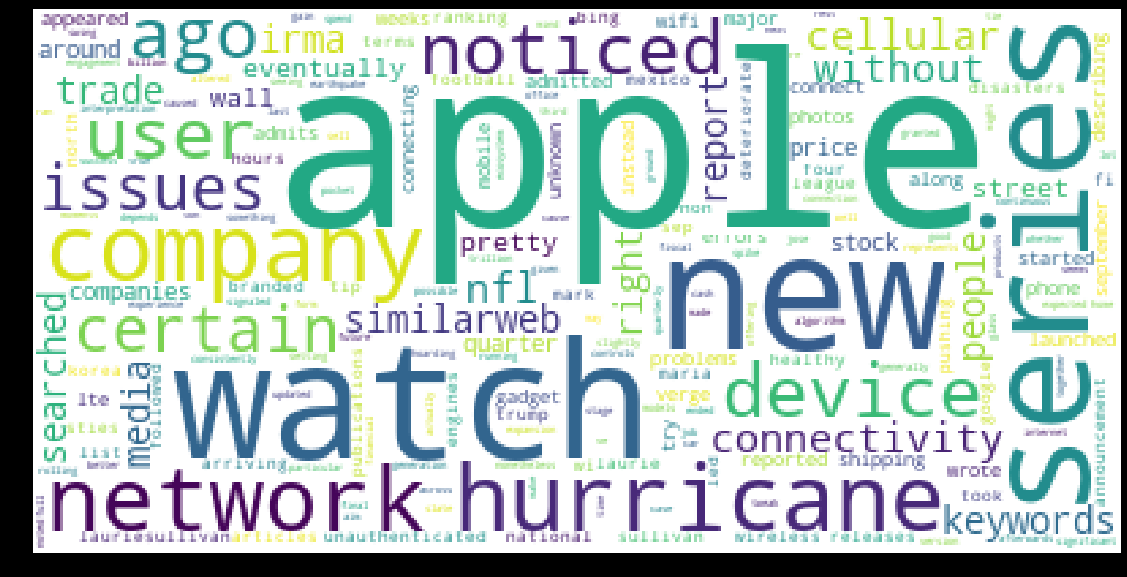

Samsung


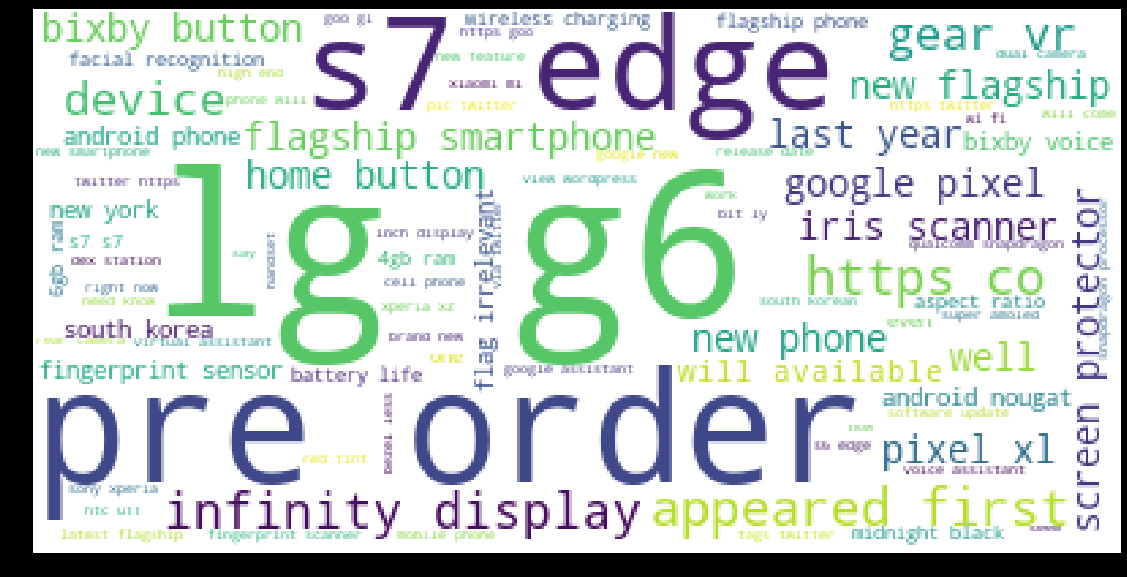

In [108]:
for device in all_data.device_type.unique():
    temp = all_data[all_data.device_type == device]
    print(device)
    wordcloud(temp,"LowerText",stopwords)
    plt.show()

Both iPhone 8 & iPhone X
Positive


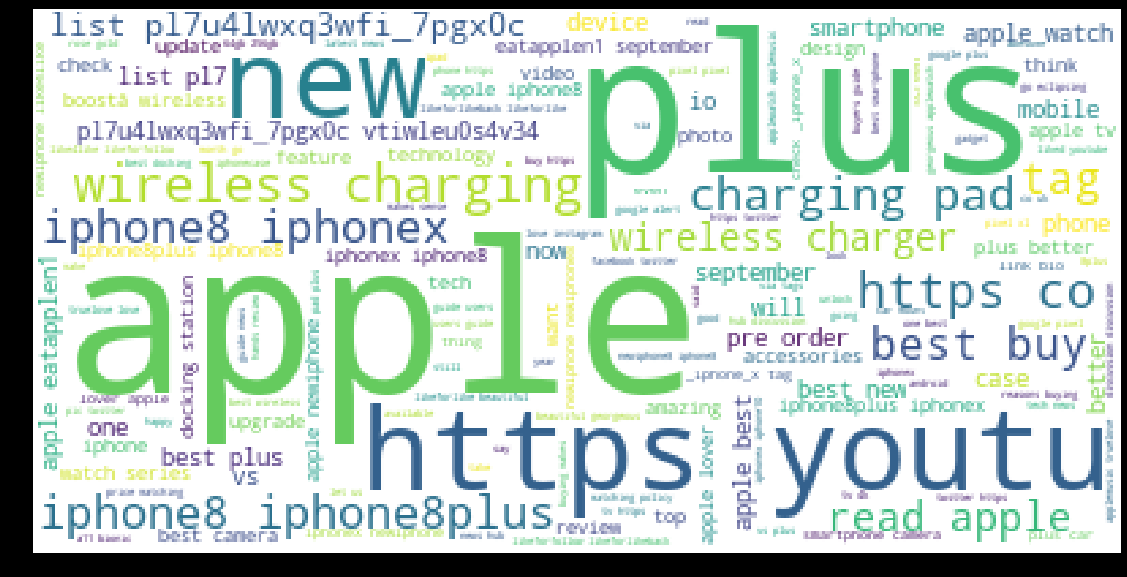

Negative


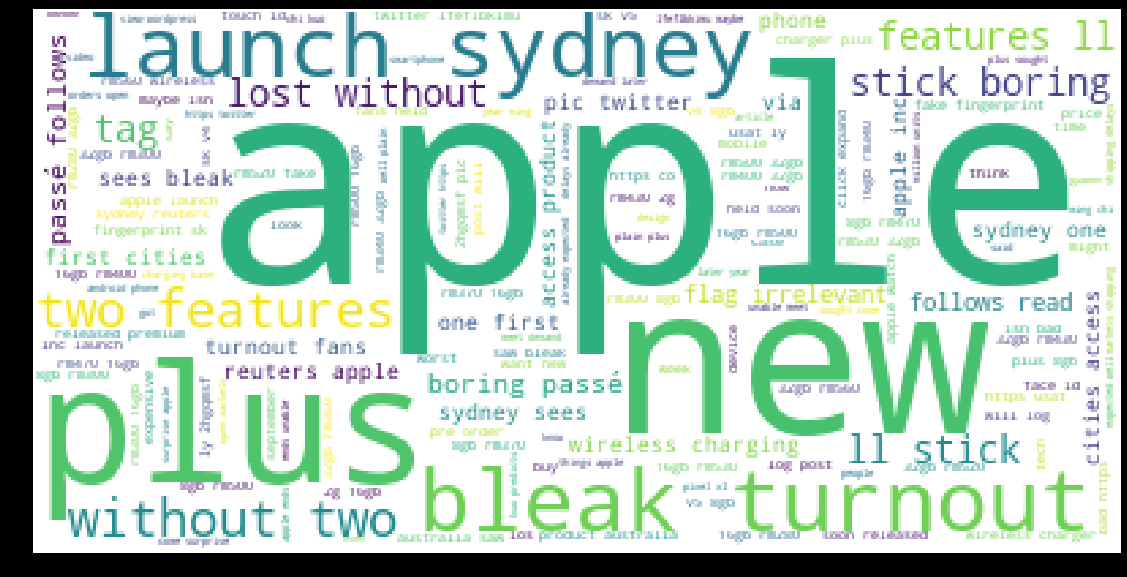

Both Samsung & iPhone
Positive


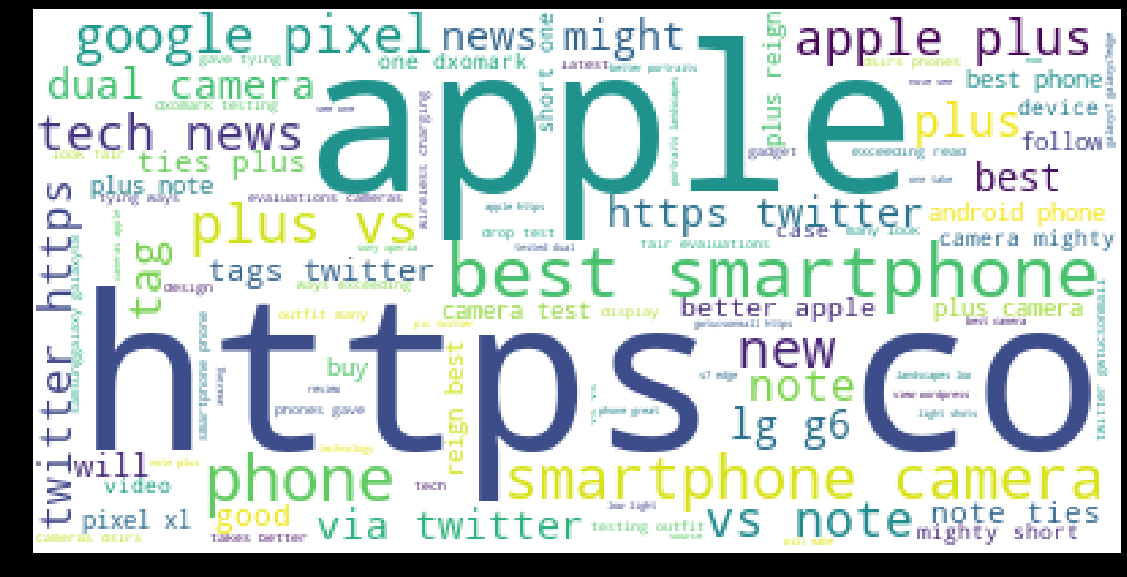

Negative


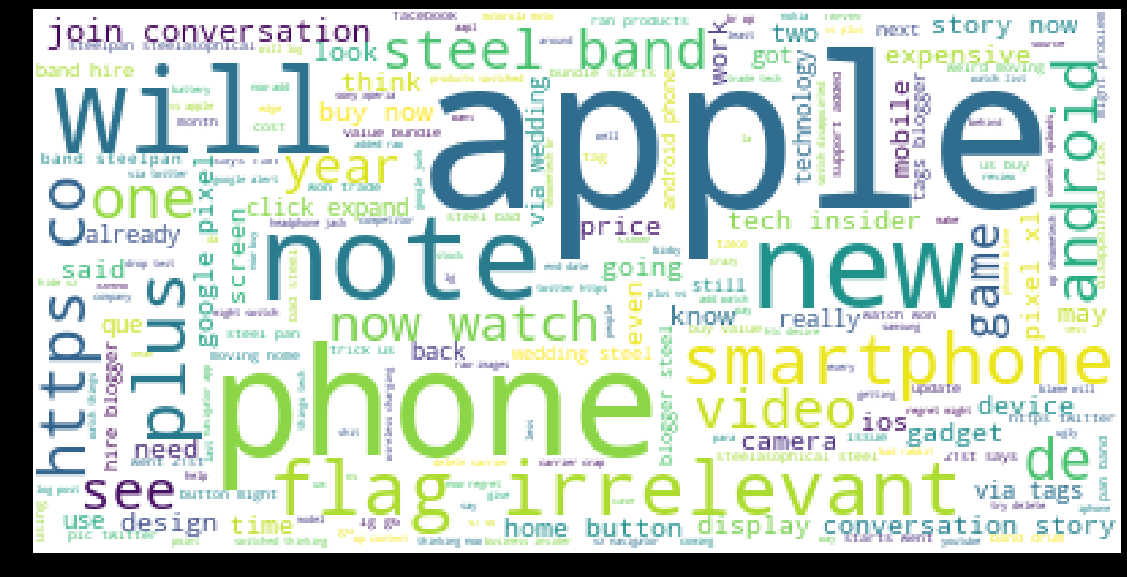

iPhone 8
Positive


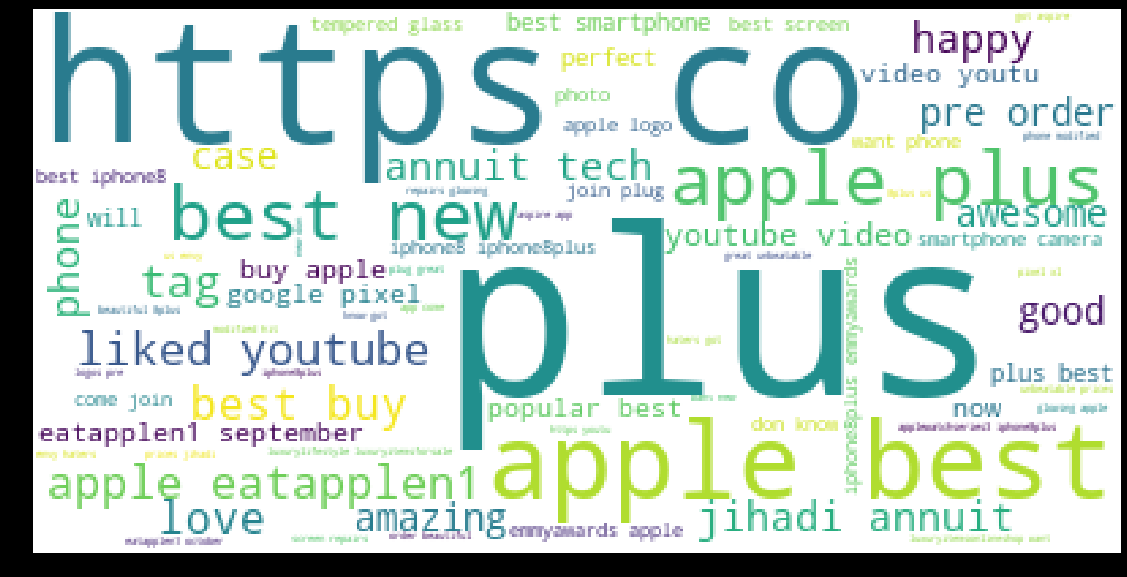

Negative


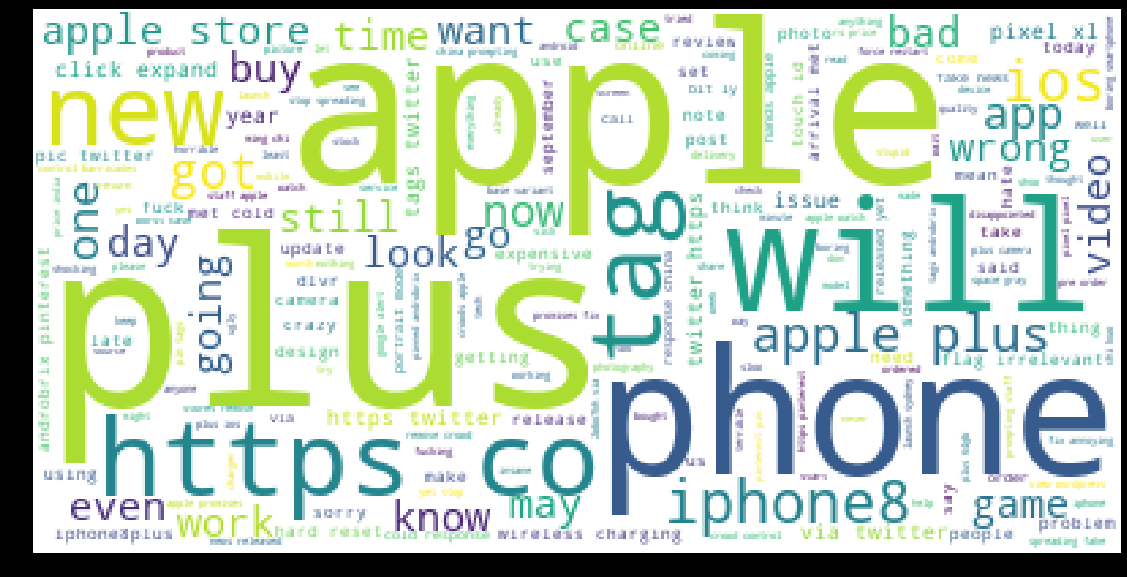

Samsung
Positive


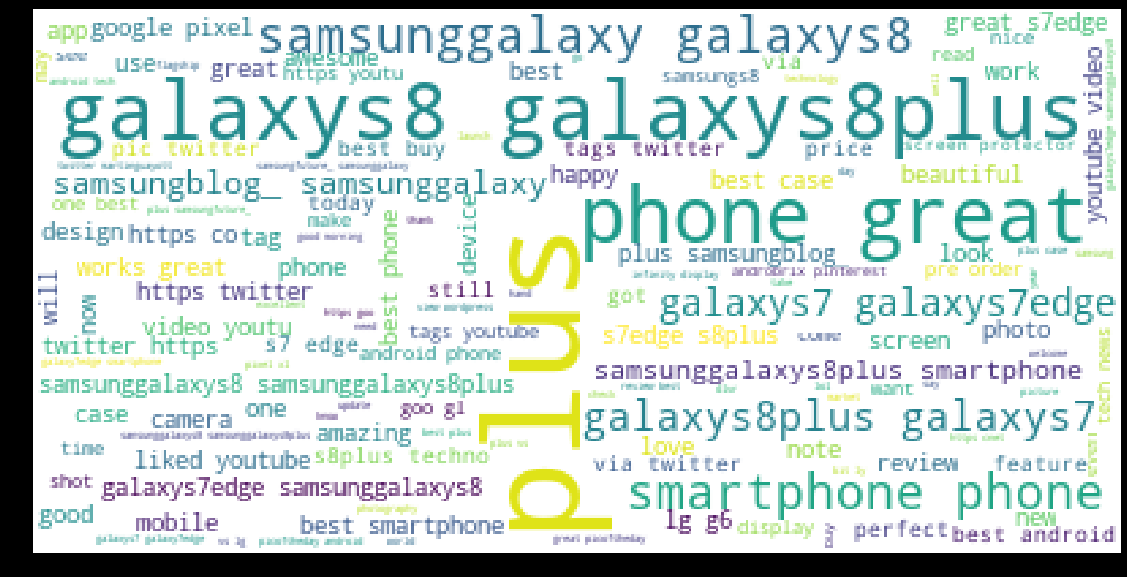

Negative


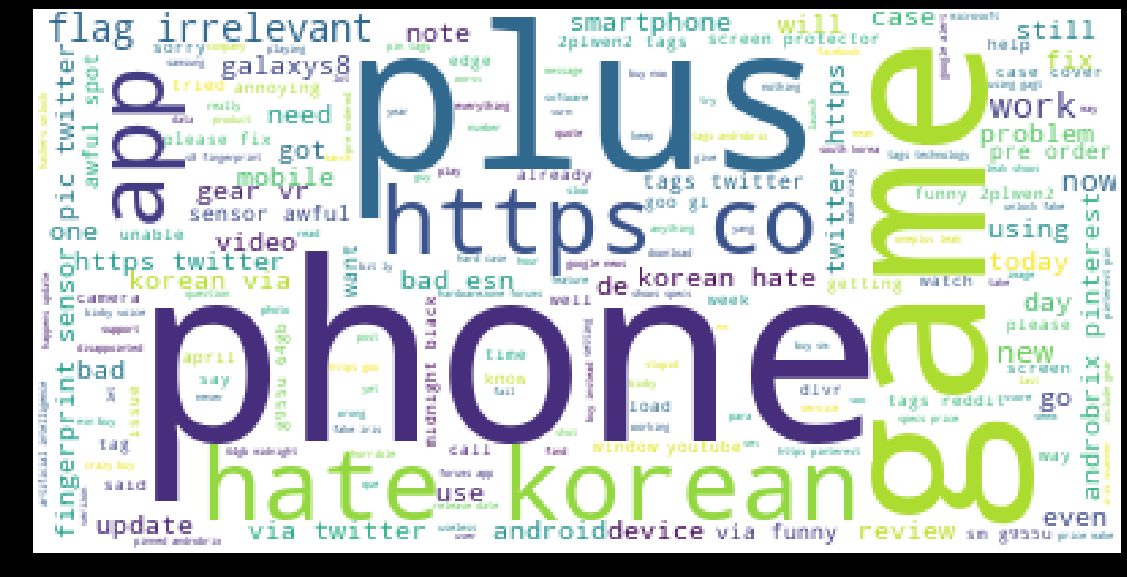

In [110]:
#positive and negative for all devices
for device in all_data.device_type.unique():
    temp = all_data[all_data.device_type == device]
    if device != "iPhone X":
        print(device)
        print("Positive")
        positive_temp = temp[temp.TextBlob_sentiment > temp.TextBlob_sentiment.mean()+ 2*temp.TextBlob_sentiment.std()]
        wordcloud(positive_temp,"LowerText",stopwords)

        plt.show()
        print("Negative")
        neg_temp = temp[temp.TextBlob_sentiment < temp.TextBlob_sentiment.mean()- 2*temp.TextBlob_sentiment.std()]
        wordcloud(neg_temp,"LowerText",stopwords)

        plt.show()